# Train Classifier

This notebook demonstrates how to train the `ctapipe` included classifier on a given set of features. These features were selected and written out by the `write_feature_table.py` script.  
Consecutively, the training is validated on a new set of events in an event-loop as you might use it during the normal reconstruction run.

In [1]:
from ipywidgets import interact, widgets
from IPython.display import display

from os.path import expandvars

from collections import namedtuple
from glob import glob

# PyTables
import tables as tb

from ctapipe.io.hessio import hessio_event_source

from ctapipe.utils import linalg
from ctapipe.utils.CutFlow import CutFlow

from ctapipe.reco.event_classifier import EventClassifier

from ctapipe.reco.HillasReconstructor import \
    HillasReconstructor, TooFewTelescopes

from tino_cta.prepare_event import EventPreparer
from tino_cta.ImageCleaning import ImageCleaner

from helper_functions import *

%matplotlib inline

# your favourite units here
energy_unit = u.TeV
angle_unit = u.deg
dist_unit = u.m

## Training
The classifier can train a separate model for the various camera types. The prediction of the event-class then takes these different camera types into account.  
Define here a list of `cam_id`s the classifier is supposed to build a model for.

In [2]:
# for which cam_id to generate a models
cam_id_list = [
        # 'GATE',
        # 'HESSII',
        'NectarCam',
        'LSTCam',
        'DigiCam',
        # 'SST-1m',
        # 'FlashCam',
        # 'ASTRICam',
        # 'SCTCam',
        ]

# the list of features to train the model on
ClassifierFeatures = namedtuple(
    "ClassifierFeatures", (
        "impact_dist",
        "sum_signal_evt",
        "max_signal_cam",
        "sum_signal_cam",
        "N_LST",
        "N_MST",
        "N_SST",
        "width",
        "length",
        "skewness",
        "kurtosis",
        "h_max",
        "err_est_pos",
        "err_est_dir"
    ))

### Setting up the feature and target dictionaries
Read in two files -- one for gammas, one for protons -- with all the feature tables that was previously written by another script. The features are collected in a dictionary with the `cam_id`s as keys. The values are the lists of "feature-lists". Every "feature-list" corresponds to one camera image and collects camera-based (e.g. the Hillas parameters) and event-based (e.g. reconstructed h_max) iniformation.
The same for the energies and classes: For every dictionary key (i.e. the camera IDs), one list for the Monte Carlo energies and one for the class of the generated parent particle is collected, corresponding to the camera-events in the `features` dictionary.  
  
Naturally, the keys in `features`, `energies` and `classes` ought to be the same...

In [3]:
features_filename_gammas = widgets.Textarea(
    value="../data/features_wave_gamma.h5",
    placeholder='Name of the gamma file to read',
    description='gamma file name',
    disabled=False
)
features_filename_protons = widgets.Textarea(
    value="../data/features_wave_proton.h5",
    placeholder='Name of the proton file to read',
    description='proton file name',
    disabled=False
)

display(features_filename_gammas, features_filename_protons)

In [4]:
features_file_gammas = tb.open_file(features_filename_gammas.value, mode="r")
features_file_proton = tb.open_file(features_filename_protons.value, mode="r")


features_file = features_file_gammas
features = {"LSTCam": [[row[name] for name in ClassifierFeatures._fields] for row in
                       features_file.root.feature_events_lst],
            "DigiCam": [[row[name] for name in ClassifierFeatures._fields] for row in
                        features_file.root.feature_events_dig],
            "NectarCam": [[row[name] for name in ClassifierFeatures._fields] for row in
                          features_file.root.feature_events_nec]}

energies = {"LSTCam": [row["MC_Energy"] for row in
                       features_file.root.feature_events_lst],
            "DigiCam": [row["MC_Energy"] for row in
                        features_file.root.feature_events_dig],
            "NectarCam": [row["MC_Energy"] for row in
                          features_file.root.feature_events_nec]}

classes = {}
for cam_id, feats in features.items():
    classes[cam_id] = ["g"] * len(feats)

#
# now protons
features_file = features_file_proton
features["LSTCam"] += [[row[name] for name in ClassifierFeatures._fields] for row in
                       features_file.root.feature_events_lst]
features["DigiCam"] += [[row[name] for name in ClassifierFeatures._fields] for row in
                        features_file.root.feature_events_dig]
features["NectarCam"] += [[row[name] for name in ClassifierFeatures._fields] for row in
                          features_file.root.feature_events_nec]
energies["LSTCam"] += [row["MC_Energy"] for row in
                       features_file.root.feature_events_lst]
energies["DigiCam"] += [row["MC_Energy"] for row in
                        features_file.root.feature_events_dig]
energies["NectarCam"] += [row["MC_Energy"] for row in
                          features_file.root.feature_events_nec]
for cam_id, feats in features.items():
    classes[cam_id] += ["p"] * (len(feats) - len(classes[cam_id]))
    energies[cam_id] = np.array(energies[cam_id]) * energy_unit


This is how one of the `features_file` and the included tables look like:

In [5]:
import pandas as pd

# print the list of tables in the file
for table in features_file_proton:
    print(table)

# print the content of one of the tables
pd.read_hdf(features_filename_protons.value, "feature_events_lst",
            mode="r")[:10]

/ (RootGroup) ''
/feature_events_dig (Table(32028,)) ''
/feature_events_lst (Table(13968,)) ''
/feature_events_nec (Table(67101,)) ''


,impact_dist,sum_signal_evt,max_signal_cam,sum_signal_cam,N_LST,N_MST,N_SST,width,length,skewness,kurtosis,h_max,err_est_pos,err_est_dir,MC_Energy
0,271.048004,2269.115967,20.442192,141.239166,4,9,0,0.044519,0.113225,-0.461832,2.034387,8671.250000,7.115962e-04,3.497656,1.099954
1,233.583023,2269.115967,63.226009,416.905426,4,9,0,0.039006,0.056876,0.050759,2.214024,8671.250000,7.115962e-04,3.497656,1.099954
2,151.979965,2269.115967,31.813305,305.418945,4,9,0,0.069087,0.160965,-0.432573,1.461751,8671.250000,7.115962e-04,3.497656,1.099954
3,341.291870,2269.115967,37.370247,310.697845,4,9,0,0.035467,0.065003,0.434911,2.877165,8671.250000,7.115962e-04,3.497656,1.099954
4,275.589905,162.427261,3.431991,24.786629,1,1,0,0.032987,0.106073,-0.171438,1.292322,2253.481934,6.918594e-14,0.000000,0.445800
5,588.438538,1177.621460,5.379014,15.966051,1,2,3,0.020065,0.025233,-0.020025,2.821117,8971.023438,4.095885e+00,7.981086,3.609693
6,449.588562,1394.017944,5.362974,22.998644,2,5,3,0.028037,0.033372,0.246999,1.833753,6364.849121,7.458680e+00,5.798989,3.609693
7,249.596832,1394.017944,8.675899,43.702473,2,5,3,0.048127,0.084054,0.737536,2.365488,6364.849121,7.458680e+00,5.798989,3.609693
8,122.388802,575.517761,26.788200,133.333969,2,2,0,0.034074,0.057203,0.395282,2.543495,-4337.306641,1.012134e+01,2.135559,0.425463
9,153.474045,575.517761,66.897995,376.071106,2,2,0,0.055590,0.059041,0.730525,2.526224,-4337.306641,1.012134e+01,2.135559,0.425463


### event weighting
For the training of the classifier, it is desirable to have the same number of events in each class to not introduce any bias in the training. Instead of throwing out events, produce weights so that all events in each [class × cam_id] bracket add up to 1.

In [6]:
telescope_weights = {}
def make_weights(unify=True):
    for cam_id, cl in classes.items():
        print(cam_id)
        cl = np.array(cl)
        telescope_weights[cam_id] = np.ones_like(cl, dtype=np.float)
        if unify:
            telescope_weights[cam_id][cl == 'g'] = \
                1 / np.count_nonzero(cl == 'g')
            telescope_weights[cam_id][cl == 'p'] = \
                1 / np.count_nonzero(cl == 'p')

        print("number of g:", np.count_nonzero(cl == 'g'))
        print("number of p:", np.count_nonzero(cl == 'p'))
        print()
_ = interact(make_weights, unify=True)

### Defining and training the model
The dictionary `clf_kwargs` sets up the behaviour of the `EventClassifier`. An optional "classifier" argument could be given to change the type of model to be created. The argument needs to be a class that has to comply to the scikit-learn typical interface.
If not given, the default is "RandomForestClassifier".  
The "cam_id_list" argument contains the list of names for which to generate a model.  
All other arguments are handed over to the class given in "classifier".

In [7]:
# use default random forest classifier
clf_kwargs = {'n_estimators': 40, 'max_depth': None,
              'min_samples_split': 2, 'random_state': 0,
              'cam_id_list': cam_id_list}

construct the classifier object and train it on the given `features` and `classes`

In [8]:
classifier = EventClassifier(**clf_kwargs)
_ = classifier.fit(features, classes, telescope_weights)

The importance of the given features to the classification can be shown like this:

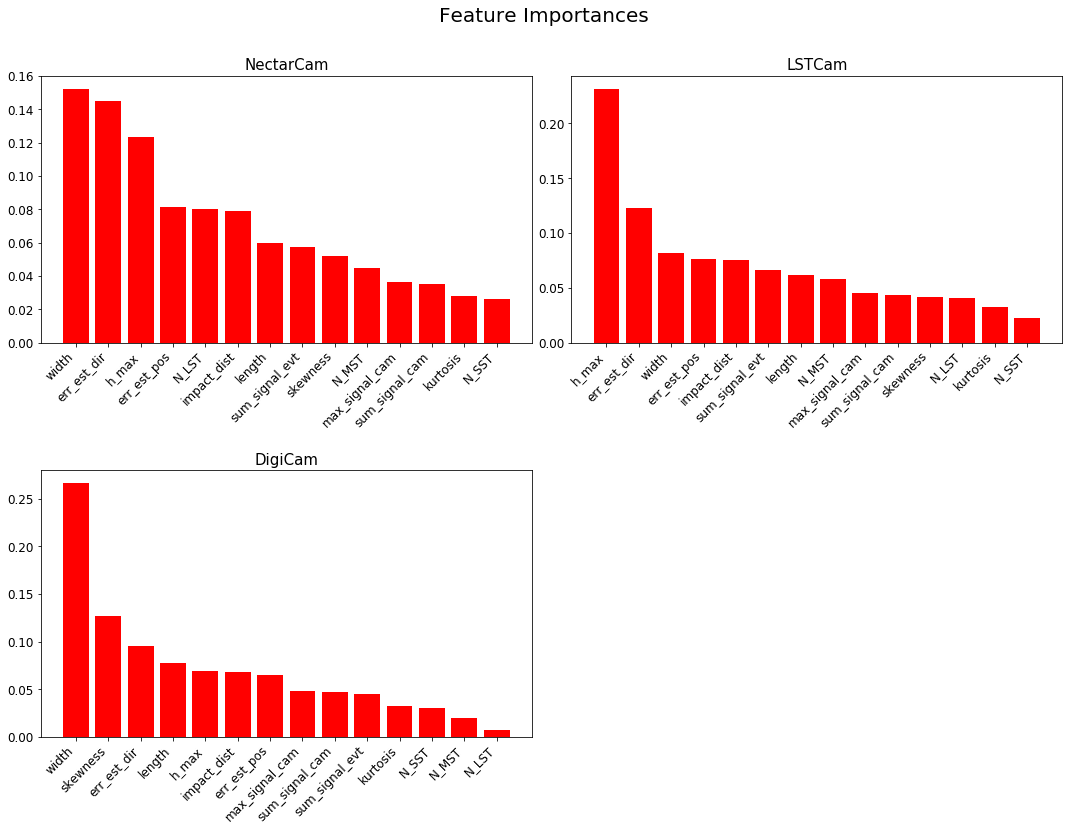

In [9]:
fig = classifier.show_importances(ClassifierFeatures._fields)
fig.set_size_inches(15, 12)
# optimise the tick-labels a bit:
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    for label in ax.get_xmajorticklabels():
        label.set_horizontalalignment("right")
plt.subplots_adjust(top=0.9, bottom=0.135, left=0.034, right=0.98,
                    hspace=0.478, wspace=0.08)

plt.show()

### Saving the model
To save the models to disc, provide a filename as a string which contains "{cam_id}". This token gets replaced by the previously given camera names, so the models are saved separately for the different camera types.

In [10]:
classifier.save("../models/classifier_{cam_id}.pckl")
glob("../models/classifier_*")

['../models/classifier_LSTCam.pckl',
 '../models/classifier_DigiCam.pckl',
 '../models/classifier_NectarCam.pckl']

### Reading the model
Reading the model back from disc works analogous to the saving:
Give the `EventClassifier.load` function a string with a "{cam_id}" token and a `cam_id_list` and it will try to load the corresponding files.  
`EventClassifier.load` is a class method and does not need an instance.

In [11]:
classifier = EventClassifier.load("../models/classifier_{cam_id}.pckl",
                                  cam_id_list)

## Cross validation
To check the performance of the trained models, load a new set of gamma and proton events, process them as usual (cf. `EventPreparer`), predict their classes and in the end compare prediction with the true class.

### Setup for reconstruction
Here, some base classes are constructed that perform the standard image cleaning, shower reconstructien, event selection etc.

In [12]:
# keeping track of events and where they were rejected
Eventcutflow = CutFlow("EventCutFlow")
Imagecutflow = CutFlow("ImageCutFlow")

# takes care of image cleaning
cleaner = ImageCleaner(mode="wave", cutflow=Imagecutflow,
                       wavelet_options=None,
                       skip_edge_events=True, island_cleaning=True)

# the class that does the shower reconstruction
shower_reco = HillasReconstructor()

preper = EventPreparer(
    cleaner=cleaner, shower_reco=shower_reco,
    event_cutflow=Eventcutflow, image_cutflow=Imagecutflow,
    # event/image cuts:
    allowed_cam_ids=[],  # [] or None means: all
    min_ntel=2,
    min_charge=25, min_pixel=3)

Imagecutflow.add_cut("features nan", lambda x: np.isnan(x).any())

In [17]:
import pyhessio
import datetime

filenamelist_gamma = sorted(glob(expandvars(
    "$CTA_DATA/Prod3b/Paranal/*simtel.gz")))
filenamelist_proton = sorted(glob(expandvars(
    "$CTA_DATA/Prod3b/Paranal/proton/*simtel.gz")))[50:]
    
energy_mc = []
gammaness = []
true_class = []

def event_loop(input_data, n_files=1, max_events=10):
    
    print("last function call:", datetime.datetime.now())
    
    # close open files and reset some arrays in case we run `interact`
    # in the next cell several times 
    try:
        pyhessio.close_file()
    except:
        pass

    global energy_mc 
    global gammaness 
    global true_class 
    energy_mc, gammaness, true_class = [], [], []

    allowed_tels = prod3b_tel_ids("L+N+D")
    for filenamelist in [filenamelist_gamma, filenamelist_proton]:
      channel = "g" if "gamma" in "".join(filenamelist) else "p"
      for i, filename in enumerate(filenamelist[:n_files]):

        print(f"{i} -- filename = {filename}")

        source = hessio_event_source(filename,
                                     allowed_tels=allowed_tels,
                                     max_events=max_events)

        # loop that cleans and parametrises the images and performs the reconstruction
        for (event, hillas_dict, n_tels,
             tot_signal, max_signals, pos_fit, dir_fit, h_max,
             err_est_pos, err_est_dir) in preper.prepare_event(source):

            # now prepare the features for the classifier
            cls_features_evt = {}
            for tel_id in hillas_dict.keys():
                Imagecutflow.count("pre-features")

                tel_pos = np.array(event.inst.tel_pos[tel_id][:2]) * u.m

                moments = hillas_dict[tel_id]

                impact_dist = linalg.length(tel_pos - pos_fit)

                cls_features_tel = ClassifierFeatures(
                    impact_dist=impact_dist / u.m,
                    sum_signal_evt=tot_signal,
                    max_signal_cam=max_signals[tel_id],
                    sum_signal_cam=moments.size,
                    N_LST=n_tels["LST"],
                    N_MST=n_tels["MST"],
                    N_SST=n_tels["SST"],
                    width=moments.width / u.m,
                    length=moments.length / u.m,
                    skewness=moments.skewness,
                    kurtosis=moments.kurtosis,
                    h_max=h_max / u.m,
                    err_est_pos=err_est_pos / u.m,
                    err_est_dir=err_est_dir / u.deg
                )

                # any nans reconstructed?
                if Imagecutflow.cut("features nan", cls_features_tel):
                    continue

                cam_id = event.inst.subarray.tel[tel_id].camera.cam_id

                try:
                    cls_features_evt[cam_id] += [cls_features_tel]
                except KeyError:
                    cls_features_evt[cam_id] = [cls_features_tel]

            if not cls_features_evt:
                continue

            predict_proba = classifier.predict_proba_by_event([cls_features_evt])
            gammaness.append(predict_proba[0, 0])
            true_class.append(channel)
            energy_mc.append(event.mc.energy / energy_unit)

    gammaness = np.array(gammaness)
    true_class = np.array(true_class)
    energy_mc = np.array(energy_mc) * energy_unit

    print("...done")


_ = interact(
    event_loop,
    input_data=expandvars("$CTA_DATA/Prod3b/Paranal/*simtel.gz"),
    n_files=(1, 10, 1),
    max_events=(0, 1000, 50)
)

### Evaluation
Define and show a few plots to assess the performance of the energy estimation:

area under curve: 0.970523796979


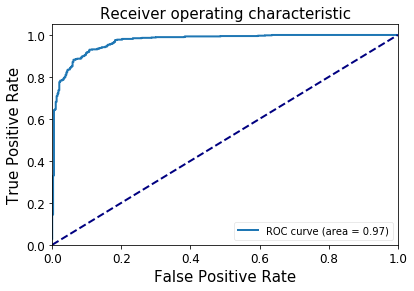

In [19]:
# plot area under curve for a few cross-validations
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_class == "g", gammaness)
roc_auc = auc(fpr, tpr)
print("area under curve:", roc_auc)

lw = 2
plt.figure()
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plot a diagonal line that represents purely random choices
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Receiver operating characteristic')
plt.show()